In [1]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import h5py
import matplotlib.pyplot as plt

import glob
import os
import _pickle as pickle
from time import time as timer
from tqdm import tqdm

path_test_filetypes = f'../output/test_filetypes/'

filetypes_subdirs = {ftype: f'{path_test_filetypes}{ftype.replace(".", "")}/' for ftype in ['.fits', '.h5', '.npy', '.pkl']}
	
for fol in ([path_test_filetypes] + list(filetypes_subdirs.values())):
	if not os.path.exists(fol):
		os.mkdir(fol)
	
np.random.seed(1923)

n_load = 1000

## Compare various file formats

Comparison on read speed for training neural networks

In [2]:
def load_fits(fname):
	with fits.open(fname, memmap=False) as hdul:
		data = hdul[0].data

	#transpose to desired shape with bands as the last axis
	# data = np.transpose(data, axes=(1, 2, 0))

	return data

def save_fits(fname, data):
	hdu = fits.PrimaryHDU(data)
	hdu.writeto(fname)

In [3]:
#clear all folders
for ftype in filetypes_subdirs.keys():
	for fname in glob.glob(f'{filetypes_subdirs[ftype]}*{ftype}'):
		os.remove(fname)
		
print(n_load)
n_digits = int(np.log10(n_load)+0.5)

### convert chosen fits files to various formats
fnames_all_filetypes = {k: [] for k in filetypes_subdirs.keys()}
for i in tqdm(range(n_load)):
	fname_only = str(i).zfill(n_digits)

	### generate random image data: 3 bands, 64 by 64 images
	data = np.random.normal(size=(3, 64, 64))
	
	###convert to the various filetypes
	#.fits
	fnames_all_filetypes['.fits'].append(f'{filetypes_subdirs[".fits"]}{fname_only}.fits')
	save_fits(fnames_all_filetypes['.fits'][-1], data)
	
	#.npy
	fnames_all_filetypes['.npy'].append(f'{filetypes_subdirs[".npy"]}{fname_only}.npy')
	np.save(fnames_all_filetypes['.npy'][-1], data)
	
	#.h5
	fnames_all_filetypes['.h5'].append(f'{filetypes_subdirs[".h5"]}{fname_only}.h5')
	h5f = h5py.File(fnames_all_filetypes['.h5'][-1], 'w')
	h5f.create_dataset('dataset_1', data=data)
	h5f.close()
	
	#pickle
	fnames_all_filetypes['.pkl'].append(f'{filetypes_subdirs[".pkl"]}{fname_only}.pkl')
	pickle.dump(data, open(fnames_all_filetypes['.pkl'][-1], 'wb'))

	

1000


100%|██████████| 1000/1000 [00:02<00:00, 368.21it/s]


In [4]:
def get_load_times(fnames_all_filetypes, do_operation=False):
	"""
	Time the file loading for various file formats
	"""
	ftypes_keys = list(fnames_all_filetypes.keys())
	loadtimes = {k: np.zeros(len(fnames_all_filetypes[ftypes_keys[0]])) for k in filetypes_subdirs.keys()}
	
	for i in tqdm(range(len(fnames_all_filetypes['.fits']))):
		### pickle
		if '.pkl' in ftypes_keys:
			starttime = timer()
			a4 = pickle.load(open(fnames_all_filetypes['.pkl'][i], 'rb'))
			if do_operation: np.mean(a4)
			loadtimes['.pkl'][i] = timer() - starttime
		### .fits
		if '.fits' in ftypes_keys:
			starttime = timer()
			a1 = load_fits(fnames_all_filetypes['.fits'][i])
			if do_operation: np.mean(a1)
			loadtimes['.fits'][i] = timer() - starttime
		### .npy
		if '.npy' in ftypes_keys:
			starttime = timer()
			a2 = np.load(fnames_all_filetypes['.npy'][i], mmap_mode=None)
			if do_operation: np.mean(a2)
			loadtimes['.npy'][i] = timer() - starttime
		### .h5
		if '.h5' in ftypes_keys:
			starttime = timer()
			with h5py.File(fnames_all_filetypes['.h5'][i], 'r', driver='core') as h5f:
				a3 = h5f['dataset_1'][:]
			if do_operation: np.mean(a3)
			loadtimes['.h5'][i] = timer() - starttime
	
	return loadtimes
	

In [5]:
def plot_load_times(loadtimes, nbins=40, n_example_files=400000, title='', savename=''):
	"""
	Plot the load times of the various file types as a histogram
	
	We also print the total load time for a hypothetical number of files
	"""
	###get hist bin edges
	alldata_appended = []
	for ftype in loadtimes.keys():
		alldata_appended.append(loadtimes[ftype])
	bin_edges = np.linspace(np.min(alldata_appended)*1000, np.percentile(alldata_appended, 99)*1000, nbins)

	fig, ax = plt.subplots(figsize=(9,6))


	print(f'Hypothetical load time for {n_example_files} images:')
	for ftype in loadtimes.keys():

		med_load_time = np.median(loadtimes[ftype])*1000

		_, _, patches = ax.hist(loadtimes[ftype]*1000, bins=bin_edges, histtype='stepfilled', label=f'{ftype} - {med_load_time:0.03f} ms', zorder=10, alpha=0.6)

		# for i in dir(patches[0]):
		# 	print(i, "  ", type(getattr(patches[0], i)))
		#also indicate the median
		ax.axvline(med_load_time, linestyle='--', zorder=12, color=patches[0]._facecolor, alpha=1, linewidth=2)

		print(f'{ftype} {med_load_time/1000*n_example_files:0.03f} s')


	ax.grid(linestyle=':', zorder=0)

	ax.legend(loc='best', title='Filetype - median loading time')

	ax.set_xlabel('Loading time [ms]')
	ax.set_ylabel('Number of tested files')
	ax.set_xlim(0)
	ax.set_title(title)
	
	#add watermark
	ax.text(0.8, 0.06, '© Jelle Mes', fontsize=10, transform=fig.transFigure)

	if len(savename) != 0:
		plt.savefig(savename, dpi=200, bbox_inches='tight', transparent=False, facecolor='white')

	return fig, ax
	

In [6]:
### now plot the distributions in load times
fig, ax = plot_load_times(
			get_load_times(fnames_all_filetypes, do_operation=True),
			nbins=40,
			title='Loading time of galaxy images into\nnumpy array (64, 64, 3) + np.mean in various filetypes',
			savename='plots/Filetypes_loading_times_single.png'
		)


100%|██████████| 1000/1000 [00:01<00:00, 647.52it/s]


Hypothetical load time for 400000 images:
.fits 230.551 s
.h5 187.778 s
.npy 92.030 s
.pkl 30.804 s


## Loading large data cubes

Each file will be re-written to larger sets, which might advantage the hdf5 files more

In [7]:
#save in batches
batch_size = 64
n_batches = 64
n_load = batch_size * n_batches

ftypes_sdir_batches = {ftype: f'{path_test_filetypes}batches_{ftype.replace(".", "")}/' for ftype in ['.fits', '.h5', '.npy', '.pkl']}

for fol in ftypes_sdir_batches.values():
	if not os.path.exists(fol):
		os.mkdir(fol)
		
#get the filenames of the fits files we want to load
fnames_fits_raw = glob.glob(f'{path_test_filetypes}fits/*.fits')

In [8]:
#clear the batches folders
for ftype in ftypes_sdir_batches.keys():
	for fname in glob.glob(f'{ftypes_sdir_batches[ftype]}*{ftype}'):
		os.remove(fname)

### load data in batches and save these batches to the various file formats
fnames_all_ftypes_batches = {k: [] for k in ftypes_sdir_batches.keys()}
for i in tqdm(range(n_batches)):
	# generate the new filename
	newfname = f'batch_{str(i).zfill(int(np.log10(n_batches)+0.5))}'
	
	### load the data as an (n, 64, 64, 3) shaped array
	data = []
	for j in range(batch_size):
		data.append(load_fits(fnames_fits_raw[i+j]))
	data = np.array(data)
		
	
	#save as fits again
	fnames_all_ftypes_batches['.fits'].append(f'{ftypes_sdir_batches[".fits"]}{newfname}.fits')
	hdu = fits.PrimaryHDU(data)
	hdu.writeto(fnames_all_ftypes_batches['.fits'][-1])
	
	
	###convert to the other filetypes
	#first .npy
	fnames_all_ftypes_batches['.npy'].append(f'{ftypes_sdir_batches[".npy"]}{newfname}.npy')
	np.save(fnames_all_ftypes_batches['.npy'][-1], data)
	
	#.h5
	fnames_all_ftypes_batches['.h5'].append(f'{ftypes_sdir_batches[".h5"]}{newfname}.h5')
	h5f = h5py.File(fnames_all_ftypes_batches['.h5'][-1], 'w')
	h5f.create_dataset('dataset_1', data=data)
	h5f.close()
	
	#pickle
	fnames_all_ftypes_batches['.pkl'].append(f'{ftypes_sdir_batches[".pkl"]}{newfname}.pkl')
	pickle.dump(data, open(fnames_all_ftypes_batches['.pkl'][-1], 'wb'))
	
	

100%|██████████| 64/64 [00:04<00:00, 13.39it/s]


100%|██████████| 64/64 [00:00<00:00, 73.68it/s]


Hypothetical load time for 400000 images:
.fits 12.328 s
.h5 21.209 s
.npy 9.738 s
.pkl 21.566 s


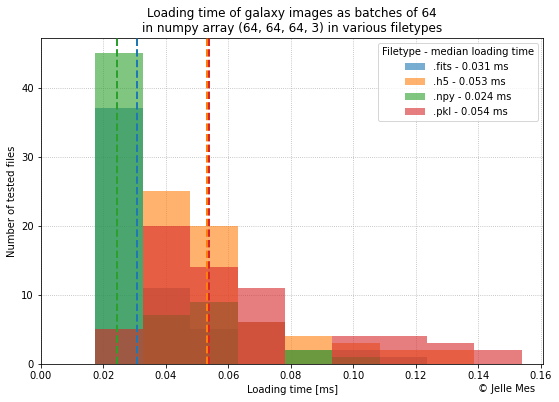

In [9]:
load_times = get_load_times(fnames_all_ftypes_batches)
#correct for the batch size
for k in load_times.keys():
	load_times[k] /= batch_size

fig, ax = plot_load_times(
			load_times,
			nbins=10,
			n_example_files=400000,
			title=f'Loading time of galaxy images as batches of {batch_size}\nin numpy array ({batch_size}, 64, 64, 3) in various filetypes',
			savename='plots/Filetypes_loading_times_batch.png'
		)

100%|██████████| 64/64 [00:01<00:00, 62.78it/s]


Hypothetical load time for 400000 images:
.fits 16.596 s
.h5 25.184 s
.npy 13.445 s
.pkl 24.389 s


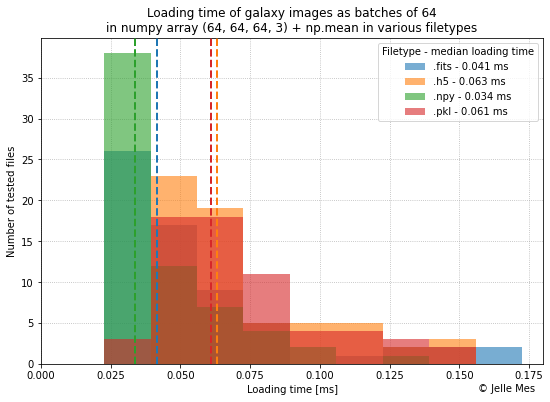

In [10]:
load_times = get_load_times(fnames_all_ftypes_batches, do_operation=True)
#correct for the batch size
for k in load_times.keys():
	load_times[k] /= batch_size

fig, ax = plot_load_times(
			load_times,
			nbins=10,
			n_example_files=400000,
			title=f'Loading time of galaxy images as batches of {batch_size}\nin numpy array ({batch_size}, 64, 64, 3) + np.mean in various filetypes',
			savename='plots/Filetypes_loading_times_batch_operation.png'
		)